In [124]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

from goatools.base import download_go_basic_obo
from goatools.base import gunzip

from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hs

from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

from adjustText import adjust_text
from anndata import AnnData
from typing import Union

In [125]:
genes_of_interest_path = (
    "/home/t.afanasyeva/MATseq/notebooks/DeSeq2/immuno_gene_symbols.txt"
)
immunoresponse_gene_df = pd.read_csv(genes_of_interest_path, sep="\t")
immunoresponse_genes = set(immunoresponse_gene_df["Approved symbol"])

In [133]:
class DataProcessor:
    def __init__(
        self,
        raw_counts: pd.DataFrame,
        classes: list[str],
        n_cpus: int,
        batches: list[str] = None,
    ):
        self.raw_counts = raw_counts
        self.classes = classes
        self.batches = batches
        self.n_cpus = n_cpus

    def prepare_counts_metadata(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        A method that checks if the list of batches was provided.
        If there are no batches, it checks the number of classes and subsets samples that belong to the classes,
        then it will prepare filtered counts and metadata. Otherwise, it will subset by class and batch and check
        if only one class was provided. Multiple batch comparisons are implemented here as only per one class!

        Returns tuple of counts and metadata

        """
        if not self.batches:
            assert (
                len(self.classes) == 2
            ), "prepare_counts_metadata() only take list with two class as a condition."

            samples_to_keep = self.raw_counts["class"].isin(self.classes)

        else:
            assert (
                len(self.classes) == 1
            ), "prepare_counts_metadata_batch_comparison_per_class() only take list with one class (str) as a condition."

            counts = self.raw_counts.copy()
            counts["batch"] = [
                gene.split("_")[1] for gene in raw_counts.index
            ]  # Retrieve batch number if the sample name as TA001_batch_class_replica

            samples_to_keep = counts["batch"].isin(self.batches) & counts["class"].isin(
                self.classes
            )  # Must provide only one class

        filtered_counts = self.raw_counts.loc[samples_to_keep]

        if not self.batches:
            metadata = filtered_counts["class"].to_frame(name="condition")
        else:
            metadata = filtered_counts["class"].to_frame(name="condition")
            metadata["group"] = filtered_counts["batch"]

        filtered_counts = filtered_counts.drop(
            ["class", "batch"], axis=1, errors="ignore"
        )
        genes_to_keep = filtered_counts.columns[filtered_counts.sum(axis=0) >= 10]

        counts = filtered_counts[genes_to_keep]

        return counts, metadata

    def make_dds(self) -> AnnData:
        if not self.batches:
            counts, metadata = self.prepare_counts_metadata()
        else:
            counts, metadata = self.prepare_counts_metadata_batch_comparison_per_class()

        dds = DeseqDataSet(
            counts=counts,
            metadata=metadata,
            design_factors=metadata.columns,
            refit_cooks=True,
            inference=DefaultInference(self.n_cpus),
        )

        dds.deseq2()

        return dds

    def make_statistics(
        self,
        padj_value: float = 0.05,
        log2foldchange_value: int = 2,
    ) -> tuple[AnnData, pd.DataFrame, pd.DataFrame]:
        dds = self.make_dds()

        if not self.batches:
            conditions_to_contrast = self.classes
            design_factor = "condition"
        else:
            conditions_to_contrast = self.batches
            design_factor = "group"

        stat_res = DeseqStats(
            dds,
            contrast=(design_factor, *conditions_to_contrast),
            inference=DefaultInference(self.n_cpus),
            quiet=True,
        )

        stat_res.summary()

        res = stat_res.results_df
        res = res[res.baseMean >= 10]
        sigs = res[
            (res.padj < padj_value) & (abs(res.log2FoldChange) > log2foldchange_value)
        ]

        return dds, res, sigs

Make histogram

In [128]:
def make_historgram_for_sign_genes(
    dds: AnnData,
    sigs: pd.DataFrame,
    results_directory: str,
    analysis_name: str,
    num_top_sig: Union[int, str],
) -> None:
    if num_top_sig != "all":
        sigs = sigs.sort_values("padj")[
            :num_top_sig
        ]  # num_top_sig can take all to plot all genes

    dds_sigs = dds[:, sigs.index]
    dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])

    grapher = pd.DataFrame(
        dds_sigs.layers["log1p"].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names
    )

    plt.figure(figsize=(12, 12))
    sns.set_theme(
        context="notebook",
        style="darkgrid",
        palette="deep",
        font="sans-serif",
        font_scale=0.55,
        color_codes=True,
        rc=None,
    )

    sns.clustermap(grapher, z_score=0, cmap="RdYlBu_r")
    plt.title(analysis_name)

    plt.savefig(
        f"{results_directory}/{analysis_name}_histo_sign.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

Make GO term analysis

In [ ]:
def initialise_go() -> None:
    # obo_fname = download_go_basic_obo()  # Already downloaded the go-basic.obo
    # fin_gene2go = gunzip("gene2go.gz")  # Already unzipped the file

    fin_gene2go = "gene2go"
    obodag = GODag("go-basic.obo")

    mapper = {}
    for key in GeneID2nt_hs:
        mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID

    objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

    """
    Get namespace2association where:
       namespace is:
           BP: biological_process
           MF: molecular_function
           CC: cellular_component
       assocation is a dict:
           key: NCBI GeneID
           value: A set of GO IDs associated with that gene
    """
    ns2assoc = objanno.get_ns2assc()

    goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(),  # List of human protein-coding genes
        ns2assoc,  # Geneid/GO associations
        obodag,  # Ontologies
        propagate_counts=False,
        alpha=0.05,  # Default significance cut-off
        methods=["fdr_bh"],  # Default multipletest correction method
    )

    go_items = []

    temp = goeaobj.ns2objgoea["BP"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["CC"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["MF"].assoc
    for item in temp:
        go_items += temp[item]

    return mapper, goeaobj, go_items


def go_it(test_genes: list[str], mapper, goeaobj, go_items):
    print(f"input genes: {len(test_genes)}")

    inv_map = {v: k for k, v in mapper.items()}

    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f"mapped genes: {len(mapped_genes)}")

    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

    GO = pd.DataFrame(
        list(
            map(
                lambda x: [
                    x.GO,
                    x.goterm.name,
                    x.goterm.namespace,
                    x.p_uncorrected,
                    x.p_fdr_bh,
                    x.ratio_in_study[0],
                    x.ratio_in_study[1],
                    go_items.count(x.GO),
                    list(map(lambda y: inv_map[y], x.study_items)),
                    x.ratio_in_study[0] / go_items.count(x.GO),
                ],
                goea_results_sig,
            )
        ),
        columns=[
            "GO",
            "term",
            "class",
            "p",
            "p_corr",
            "n_genes",
            "n_study",
            "n_go",
            "study_genes",
            "per",
        ],
    )

    GO = GO[GO.n_genes > 1]
    return GO


def make_go_plot(df, results_directory, analysis_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = mpl.cm.bwr_r
    norm = mpl.colors.Normalize(vmin=df.p_corr.min(), vmax=df.p_corr.max())
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    sns.barplot(
        data=df,
        x="per",
        y="term",
        palette=list(mapper.to_rgba(df.p_corr.values)),
        ax=ax,
    )
    ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])

    cbar = fig.colorbar(mapper, ax=ax, orientation="vertical", pad=0.01)
    cbar.ax.set_position([0.8, 0.5, 0.2, 0.3])
    plt.title(analysis_name)

    plt.savefig(
        f"{results_directory}/{analysis_name}_go.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )


mapper, goeaobj, go_items = initialise_go()

Make Volcano plot

In [ ]:
genes_of_interest_path = (
    "/home/t.afanasyeva/MATseq/notebooks/DeSeq2/immuno_gene_symbols.txt"
)
immunoresponse_gene_df = pd.read_csv(genes_of_interest_path, sep="\t")
immunoresponse_genes = set(immunoresponse_gene_df["Approved symbol"])


def map_color(gene, overexpressed, underexpressed):
    if gene in overexpressed:
        return "overexpressed"
    elif gene in underexpressed:
        return "underexpressed"
    else:
        return "no_expression_change"


def map_shape(gene, immunoresponse_genes):
    if gene in immunoresponse_genes:
        return "immunoresponse"
    else:
        return "no_immunoresponse"


def make_volcano_plot(
    res: pd.DataFrame,
    genes_of_interest: set[str],
    results_directory: str,
    analysis_name: str,
    sign_log2FoldChange: int = 2,
    sign_padj: float = 0.05,
) -> None:
    sign_genes = res[(res["padj"] < sign_padj)]
    overexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] > sign_log2FoldChange)].index
    )
    underexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] < -sign_log2FoldChange)].index
    )

    df = res.reset_index(names="gene")
    df["padj_log"] = -np.log10(df["padj"])

    df["color"] = df.apply(
        lambda row: map_color(row["gene"], overexpressed, underexpressed),
        axis=1,
    )

    df["shape"] = df.apply(
        lambda row: map_shape(row["gene"], genes_of_interest),
        axis=1,
    )

    plt.figure(figsize=(10, 12))
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(context="notebook", style="white", rc=custom_params)
    plt.title(analysis_name)

    ax = sns.scatterplot(
        data=df,
        x="log2FoldChange",
        y="padj_log",
        hue="color",
        hue_order=["no_expression_change", "overexpressed", "underexpressed"],
        palette=["grey", "orange", "purple"],
        style="shape",
        style_order=["immunoresponse", "no_immunoresponse"],
        markers=["s", "o"],
        size="baseMean",
        sizes=(20, 200),
    )

    ax.axhline(1.3, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(2, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(-2, zorder=1, c="k", lw=1, ls="--")

    ax.tick_params(width=2)

    texts = []
    for i in range(len(df)):
        if (
            df.iloc[i].padj < sign_padj
            and abs(df.iloc[i].log2FoldChange) > sign_log2FoldChange
        ):
            texts.append(
                plt.text(
                    x=df.iloc[i].log2FoldChange,
                    y=df.iloc[i].padj_log,
                    s=df.iloc[i].gene,
                    fontsize=10,
                    weight="bold",
                )
            )

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k"))
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1), frameon=False, prop={"weight": "bold"})

    plt.xticks(size=10, weight="bold")
    plt.yticks(size=10, weight="bold")

    plt.xlabel("$log_{2}$ fold change")
    plt.ylabel("-$log_{10}$ FDR")

    plt.savefig(
        f"{results_directory}/{analysis_name}_volcano.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

Make PCA, t-SNE, umap

In [ ]:
def make_pca(
    dds: AnnData,
    results_directory: str,
    analysis_name: str,
) -> None:
    sc.tl.pca(dds, n_comps=2)
    pca = dds.obsm["X_pca"]
    sample_names = list(sc.get.obs_df(dds).index)  # get sample names
    sns.set_theme(
        context="notebook",
        style="white",
        palette="deep",
        font="sans-serif",
        font_scale=0.6,
        color_codes=True,
        rc=None,
    )

    plt.figure(figsize=(12, 12))
    ax = sc.pl.pca(
        dds, title=f"PCA_{analysis_name}", color="condition", size=300, show=False
    )  # color can also be group

    texts = [
        plt.text(pca[i][0], pca[i][1], sample_names[i], ha="left", va="bottom")
        for i in range(len(pca))
    ]  #

    plt.tight_layout(w_pad=2)
    plt.savefig(f"{results_directory}/pca_{analysis_name}.png")


def make_tsne(
    dds: AnnData,
    results_directory: str,
    analysis_name: str,
) -> None:
    sc.tl.tsne(dds, n_pcs=2)
    tsne = dds.obsm["X_tsne"]
    sample_names = list(sc.get.obs_df(dds).index)  # get sample names
    sns.set_theme(
        context="notebook",
        style="white",
        palette="deep",
        font="sans-serif",
        font_scale=0.6,
        color_codes=True,
        rc=None,
    )

    plt.figure(figsize=(12, 12))
    ax = sc.pl.tsne(
        dds, title=f"t-SNE_{analysis_name}", color="condition", size=300, show=False
    )  # color can also be group

    texts = [
        plt.text(tsne[i][0], tsne[i][1], sample_names[i], ha="left", va="bottom")
        for i in range(len(tsne))
    ]  #

    plt.tight_layout(w_pad=2)
    plt.savefig(f"{results_directory}/tsne_{analysis_name}.png")


def make_umap(
    dds: AnnData,
    results_directory: str,
    analysis_name: str,
) -> None:
    sc.pp.neighbors(dds)
    sc.tl.umap(dds)
    umap = dds.obsm["X_umap"]
    sample_names = list(sc.get.obs_df(dds).index)  # get sample names
    sns.set_theme(
        context="notebook",
        style="white",
        palette="deep",
        font="sans-serif",
        font_scale=0.6,
        color_codes=True,
        rc=None,
    )

    plt.figure(figsize=(12, 12))
    ax = sc.pl.umap(
        dds, title=f"umap_{analysis_name}", color="condition", size=300, show=False
    )  # color can also be group

    texts = [
        plt.text(umap[i][0], umap[i][1], sample_names[i], ha="left", va="bottom")
        for i in range(len(umap))
    ]

    plt.tight_layout(w_pad=2)
    plt.savefig(f"{results_directory}/umap_{analysis_name}.png")

In [ ]:
file_path = "gene_counts_all_batches_157_samples_deseq2.csv"
raw_counts = pd.read_csv(file_path, index_col="sample")

In [ ]:
# raw_counts["batch"] = [
#     gene.split("_")[1] for gene in raw_counts.index
# ]  # Retrieve batch number if the sample name as TA001_batch_class_replica
# batches = set(raw_counts["batch"])
# class_to_check = ["IMDM"]

# count, meta = prepare_counts_metadata_batch_comparison_per_class(
#     raw_counts, class_to_check, batches
# )

In [ ]:
list_of_classes_to_include = []
for my_class in raw_counts["class"].unique():
    if my_class != "IMDM":
        list_of_classes_to_include.append([my_class, "IMDM"])

In [ ]:
current_directory = os.getcwd()

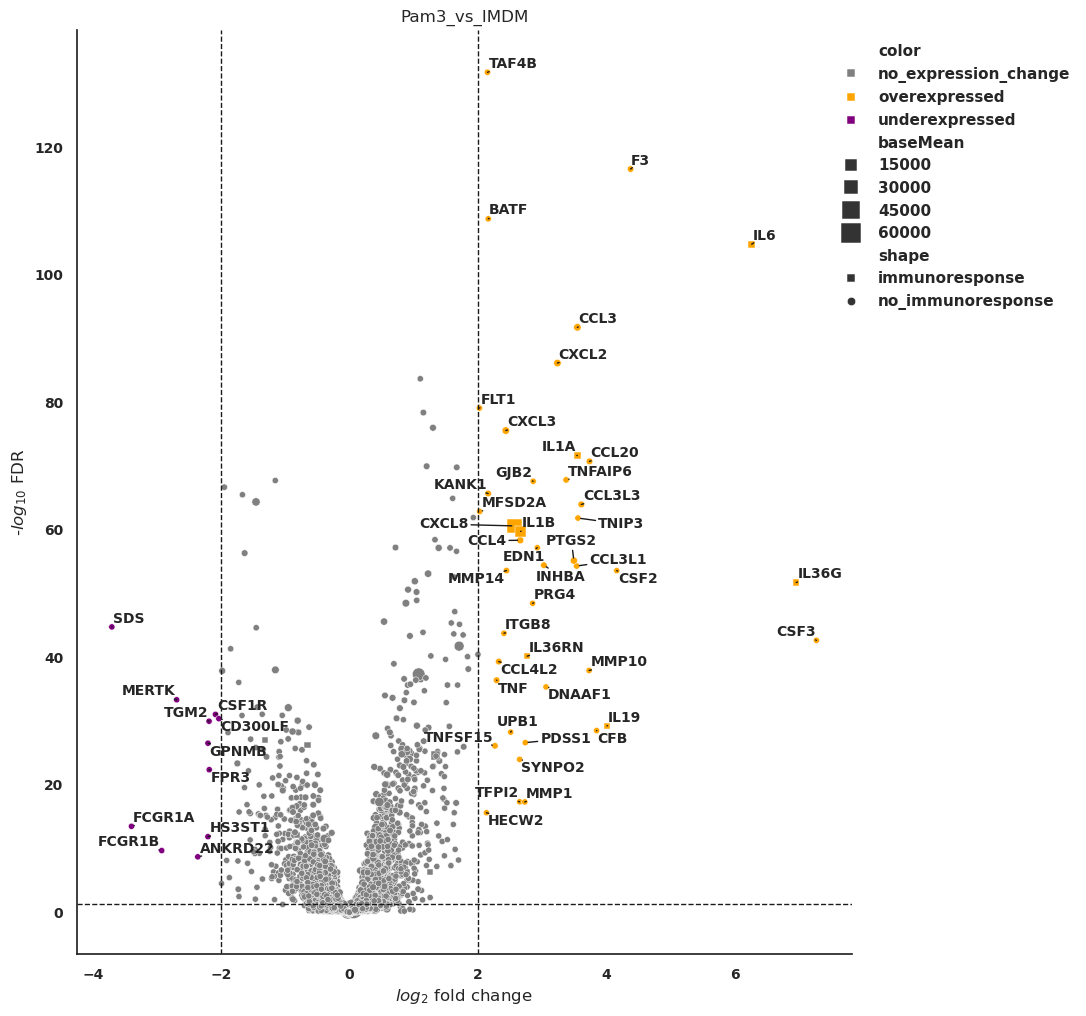

<Figure size 1200x1200 with 0 Axes>

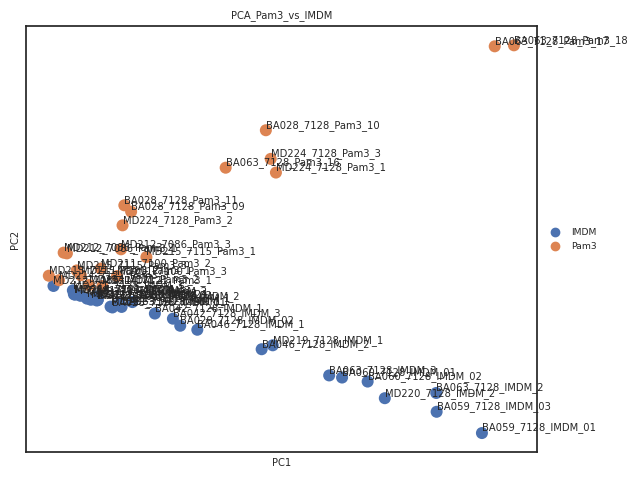

<Figure size 1200x1200 with 0 Axes>

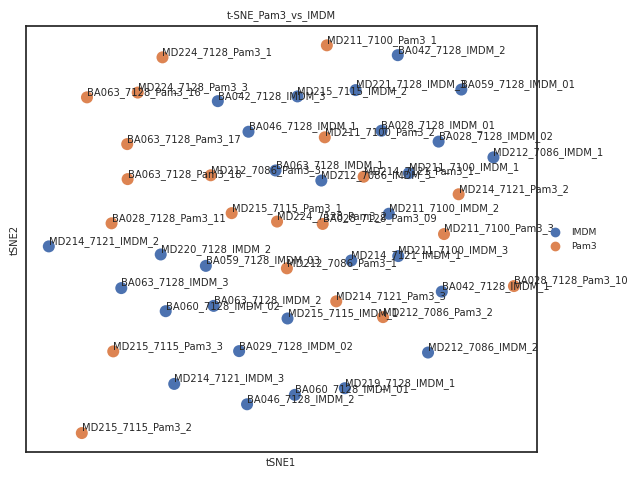

<Figure size 1200x1200 with 0 Axes>

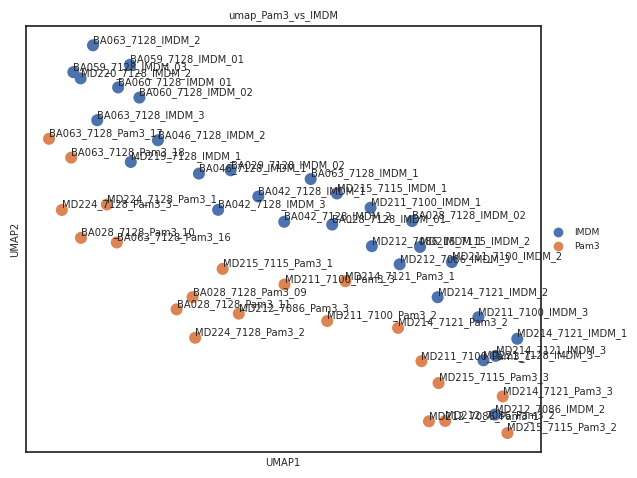

<Figure size 1200x1200 with 0 Axes>

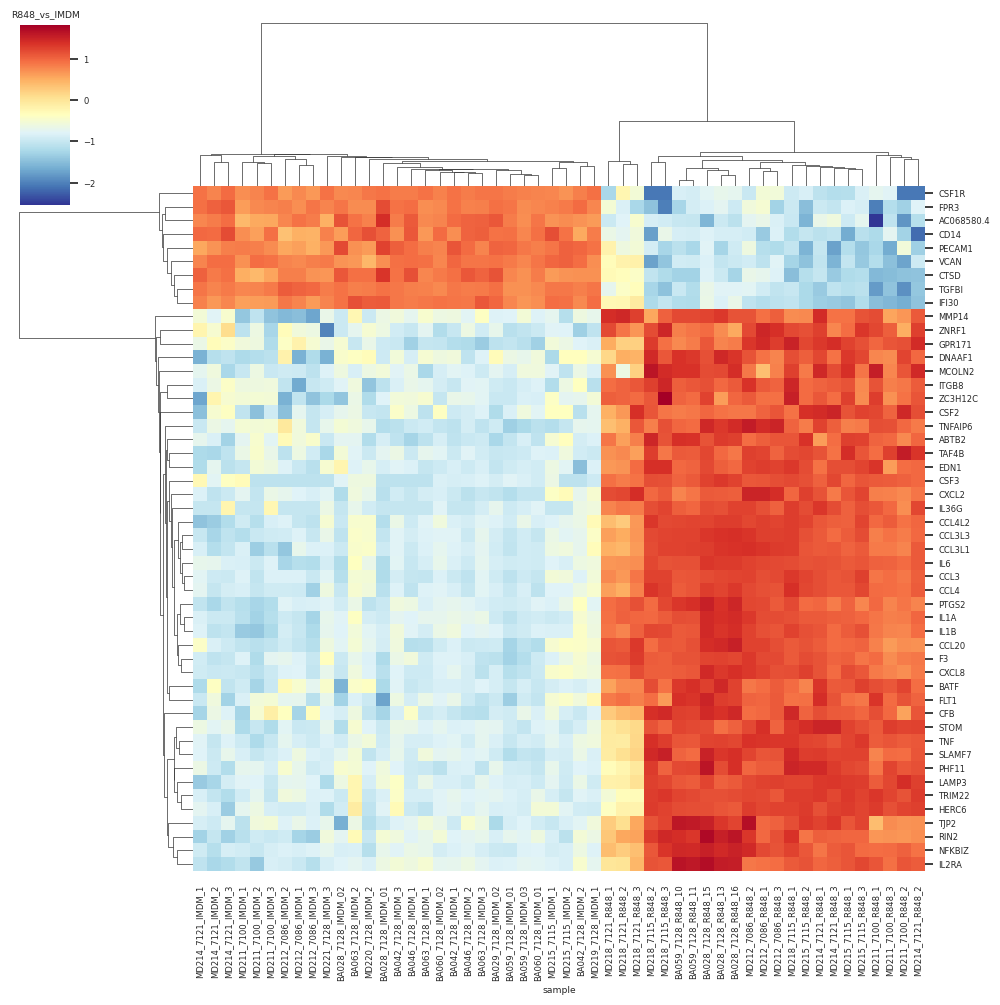

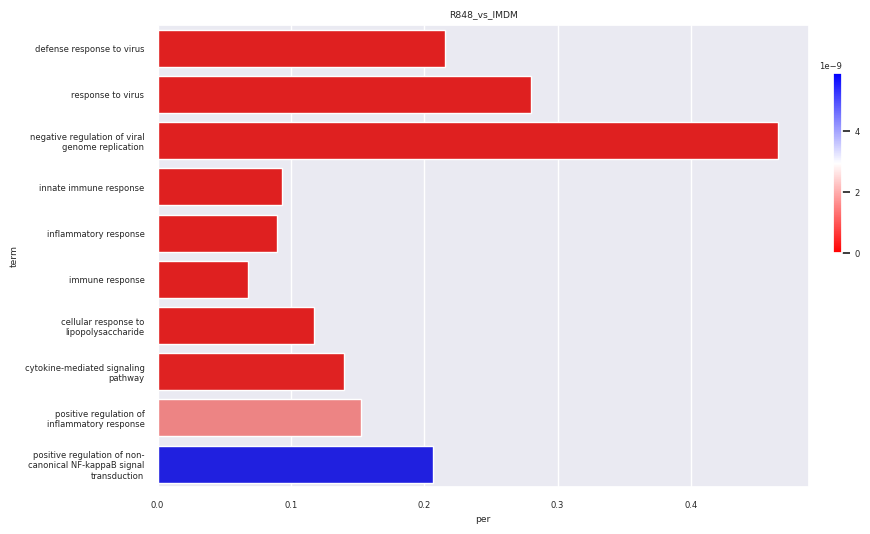

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


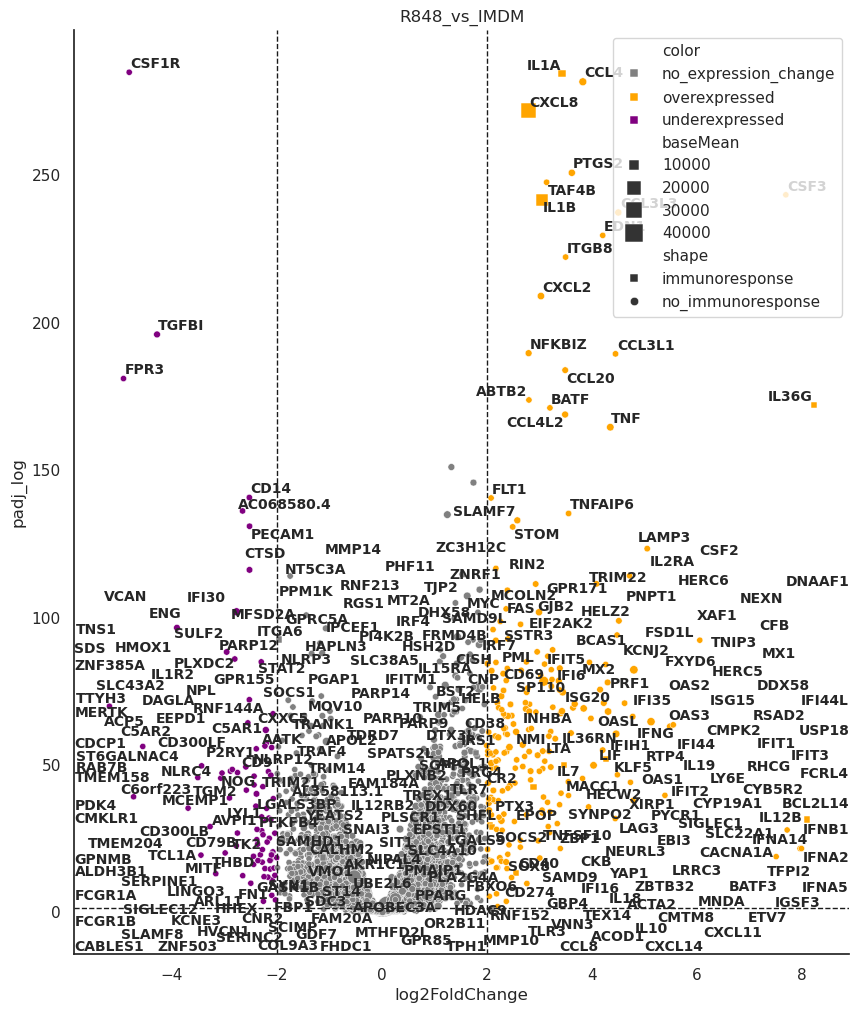

In [134]:
for class_pair in list_of_classes_to_include:
    analysis_name = f"{class_pair[0]}_vs_{class_pair[1]}"

    results_directory = os.path.join(current_directory, analysis_name)
    if not os.path.exists(results_directory):
        os.makedirs(results_directory)

    dataprocessor = DataProcessor(
        raw_counts=raw_counts, classes=class_pair, batches=None, n_cpus=16
    )

    dds, res, sigs = dataprocessor.make_statistics()

    _ = make_historgram_for_sign_genes(
        dds, sigs, results_directory, analysis_name, num_top_sig=50
    )

    go_df = go_it(sigs.index, mapper, goeaobj, go_items)
    _ = make_go_plot(go_df[0:10], results_directory, analysis_name)

    _ = make_volcano_plot(res, immunoresponse_genes, results_directory, analysis_name)

    _ = make_pca(dds, results_directory, analysis_name)
    _ = make_tsne(dds, results_directory, analysis_name)
    _ = make_umap(dds, results_directory, analysis_name)